In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [26]:
from importlib import reload
reload(plt)

<module 'matplotlib.pyplot' from '/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import math as mt
import datetime as dt
import random as ran
from sklearn.metrics.pairwise import euclidean_distances as euc
from functools import reduce
import warnings

# 한글출력
matplotlib.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings(action='ignore') 

from src import crs
from IPython.display import clear_output, Markdown, display

In [7]:
# 1. load_excel
data_path = "data/apt_1.xlsx"
xlsx = pd.read_excel(data_path, header=None,
                     skiprows=2, engine="openpyxl")

# 2. data preprocessing
p, m = crs.utils.data_preprocessing(xlsx)

m.set_index("month", inplace=True)

# 3. data init
_month = 1

month_df = pd.DataFrame(m.loc[_month])
month_df.reset_index(inplace=True)

month_df.columns = ['name', 'usage (kWh)']

PUBLIC_PERCENTAGE = 30
APT = crs.utils.get_APT(month_df, PUBLIC_PERCENTAGE)

calc = crs.models.ManagementOffice(
        month=_month,
        households=month_df,
        APT=APT,
        contract="단일계약"
    )
apt = calc.apart

In [14]:
crs.utils.print_apt_info(_month, month_df, APT)

hh, anal = crs.utils.get_analysis_df(_month,month_df, APT)
anal = anal[anal.columns[:-1]]
anal['최종청구금액'] = anal.sum(axis=1).astype('int')
anal.head()

APT : 44,434kWh (평균 사용량: 411kWh)
		6,439,540원
세대부 : 31,104kWh (70%) (평균 사용량: 288kWh)
		3,798,980원
공용부 : 13,330kWh (30%) (평균 사용량: 123kWh)
		2,640,560원


,기본요금,전력량요금,기후환경요금,연료비 조정액,VAT,전력산업기반기금,최종청구금액
APT,654480,4907088,235224,-133164,566363,209550,6439541
세대부,197480,3118820,164805,-93312,334205,123150,3845148
공용부,457000,1788268,70419,-39852,232158,86400,2594393
세대부 / APT percentage,30,64,70,70,59,59,352
공용부 / APT percentage,70,36,30,30,41,41,248


# 데이터 소개
- 해당 데이터는 108가구의 1년치 월 별 사용량 데이터를 가지고 있는 데이터이다.
- 이 중, 1월달 데이터를 이용하여 공용부의 전기요금 구성요소들의 특징을 살펴보도록 한다.

In [20]:
m[m.columns[:10]]

,아파트1-101-1002,아파트1-101-104,아파트1-101-1102,아파트1-101-1202,아파트1-101-1302,아파트1-101-1401,아파트1-101-1403,아파트1-101-1502,아파트1-101-1504,아파트1-101-1602
month,,,,,,,,,,
1,253,689,183,239,455,343,380,219,389,350
2,251,481,177,218,397,297,339,197,348,288
3,255,424,203,222,378,303,349,202,357,368
4,252,355,180,230,368,278,298,188,346,365
5,230,357,258,203,414,270,418,156,320,265
6,212,363,272,207,411,275,398,149,265,254
7,326,423,416,204,597,350,477,210,374,441
8,431,454,450,207,701,411,505,236,385,533
9,207,334,198,188,445,299,369,153,261,258


# 기본요금

## 10%에서부터 40%까지 늘려가면서 진행한 공용부 기본요금의 변화

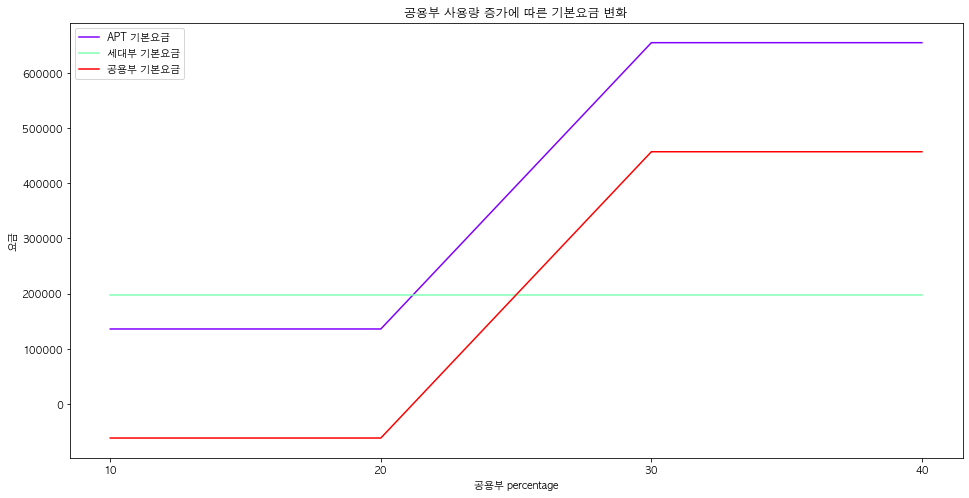

,10%,20%,30%,40%
APT,136080,136080,654480,654480
세대부,197480,197480,197480,197480
공용부,-61400,-61400,457000,457000


In [32]:
basic_df = pd.DataFrame(index=['APT', '세대부', '공용부'])

for PUBLIC_PERCENTAGE in range(10, 50, 10):
    APT = crs.utils.get_APT(month_df, PUBLIC_PERCENTAGE)
    _, anal_df = crs.utils.get_analysis_df(_month, month_df, APT)
    
    basic_df["{}%".format(PUBLIC_PERCENTAGE)] = \
        anal_df['기본요금'].values[:3]
    
plt.figure(figsize=(16,8))
palette = plt.cm.get_cmap("rainbow", len(basic_df))
for idx,(index_name, row) in enumerate(basic_df.iterrows()):
    plt.plot(range(10,50,10),row.values, c=palette(idx), 
             label="{} 기본요금".format(index_name))

plt.xticks(range(10,50,10))
plt.title("공용부 사용량 증가에 따른 기본요금 변화")
plt.ylabel("요금")
plt.xlabel("공용부 percentage")
plt.legend(loc='upper left')
plt.show()

basic_df[basic_df.columns[:5]]

## 공용부의 평균사용량을 1kWh씩 증가시키면서 변화를 확인

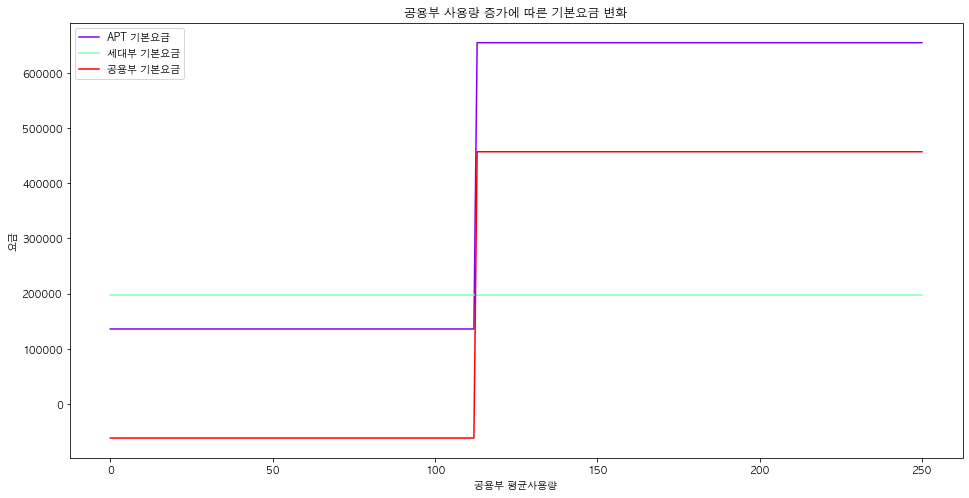

,0.0kWh,1.0kWh,2.0kWh,3.0kWh,4.0kWh
APT,136080,136080,136080,136080,136080
세대부,197480,197480,197480,197480,197480
공용부,-61400,-61400,-61400,-61400,-61400


In [40]:
basic_df = pd.DataFrame(index=['APT', '세대부', '공용부'])

for public_kWh in range(0, 27108, 108):
    APT = month_df['usage (kWh)'].sum() + public_kWh
    _, anal_df = crs.utils.get_analysis_df(_month, month_df, APT)
    
    basic_df["{}kWh".format(round(public_kWh) / 108)] = \
        anal_df['기본요금'].values[:3]
    
plt.figure(figsize=(16,8))
palette = plt.cm.get_cmap("rainbow", len(basic_df))
for idx,(index_name, row) in enumerate(basic_df.iterrows()):
    plt.plot(range(0, 251),row.values, c=palette(idx), 
             label="{} 기본요금".format(index_name))

plt.title("공용부 사용량 증가에 따른 기본요금 변화")
plt.ylabel("요금")
plt.xlabel("공용부 평균사용량")
plt.legend(loc='upper left')
plt.show()

basic_df[basic_df.columns[:5]]

## 세대부 사용량 구성에 따라 달라지는 공용부의 기본요금

In [47]:
step_df = month_df.copy()
step_df['누진단계'] = np.array([crs.utils.get_nugin_step(_, calc.fee) 
                   for _ in month_df['usage (kWh)']]) + 1

step_count = pd.DataFrame(
    step_df['누진단계'].groupby(step_df['누진단계']).count())
step_count.columns = ['가구 수']
step_count['기본요금'] = [_[2] for _ in calc.fee]
step_count['토탈'] = \
    step_count.apply(lambda x: x['가구 수'] * x['기본요금'], axis=1)

step_count.loc['세대부 토탈'] = step_count.sum(axis=0)

step_count

,가구 수,기본요금,토탈
누진단계,,,
1,20,730,14600
2,73,1260,91980
3,15,6060,90900
세대부 토탈,108,8050,197480


# 2. 전력량요금
---
- 공용부의 전력량요금은 APT 평균사용량 안에서 세대부 평균사용량 이후의 누진단계부터 가격 산정이 시작된다.

## 10%에서부터 40%까지 늘려가면서 진행한 공용부 기본요금의 변화

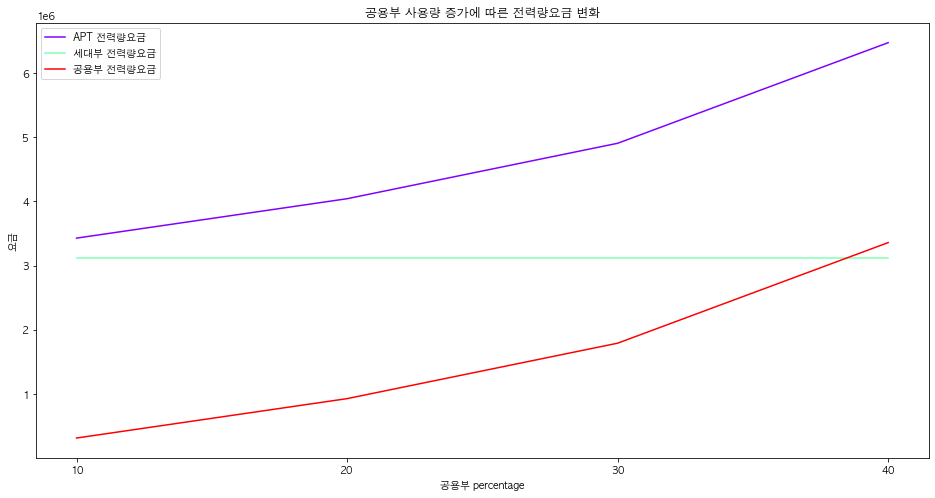

,10%,20%,30%,40%
APT,3427488,4042224,4907088,6476544
세대부,3118820,3118820,3118820,3118820
공용부,308668,923404,1788268,3357724


In [49]:
basic_df = pd.DataFrame(index=['APT', '세대부', '공용부'])

for PUBLIC_PERCENTAGE in range(10, 50, 10):
    APT = crs.utils.get_APT(month_df, PUBLIC_PERCENTAGE)
    _, anal_df = crs.utils.get_analysis_df(_month, month_df, APT)
    
    basic_df["{}%".format(PUBLIC_PERCENTAGE)] = \
        anal_df['전력량요금'].values[:3]
    
plt.figure(figsize=(16,8))
palette = plt.cm.get_cmap("rainbow", len(basic_df))
for idx,(index_name, row) in enumerate(basic_df.iterrows()):
    plt.plot(range(10,50,10),row.values, c=palette(idx), 
             label="{} 전력량요금".format(index_name))

plt.xticks(range(10,50,10))
plt.title("공용부 사용량 증가에 따른 전력량요금 변화")
plt.ylabel("요금")
plt.xlabel("공용부 percentage")
plt.legend(loc='upper left')
plt.show()

basic_df[basic_df.columns[:5]]

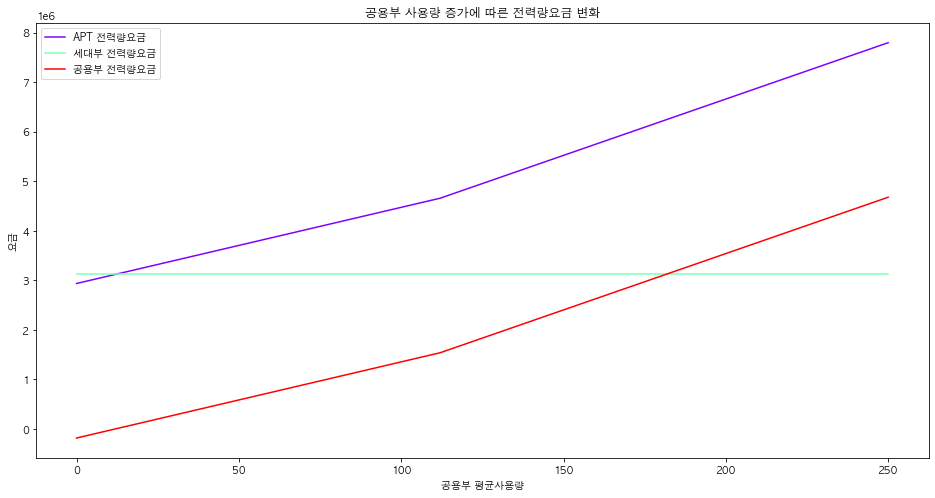

,0.0kWh,1.0kWh,2.0kWh,3.0kWh,4.0kWh
APT,2935656,2950992,2966436,2981772,2997108
세대부,3118820,3118820,3118820,3118820,3118820
공용부,-183164,-167828,-152384,-137048,-121712


In [50]:
basic_df = pd.DataFrame(index=['APT', '세대부', '공용부'])

for public_kWh in range(0, 27108, 108):
    APT = month_df['usage (kWh)'].sum() + public_kWh
    _, anal_df = crs.utils.get_analysis_df(_month, month_df, APT)
    
    basic_df["{}kWh".format(round(public_kWh) / 108)] = \
        anal_df['전력량요금'].values[:3]
    
plt.figure(figsize=(16,8))
palette = plt.cm.get_cmap("rainbow", len(basic_df))
for idx,(index_name, row) in enumerate(basic_df.iterrows()):
    plt.plot(range(0, 251),row.values, c=palette(idx), 
             label="{} 전력량요금".format(index_name))

plt.title("공용부 사용량 증가에 따른 전력량요금 변화")
plt.ylabel("요금")
plt.xlabel("공용부 평균사용량")
plt.legend(loc='upper left')
plt.show()

basic_df[basic_df.columns[:5]]

In [53]:
basic_df[basic_df.columns[111:]]

,111.0kWh,112.0kWh,113.0kWh,114.0kWh,115.0kWh,116.0kWh,117.0kWh,118.0kWh,119.0kWh,120.0kWh,...,241.0kWh,242.0kWh,243.0kWh,244.0kWh,245.0kWh,246.0kWh,247.0kWh,248.0kWh,249.0kWh,250.0kWh
APT,4641516,4656960,4679640,4702428,4725108,4747896,4770684,4793364,4816152,4838832,...,7590996,7613784,7636464,7659252,7681932,7704720,7727508,7750188,7772976,7795656
세대부,3118820,3118820,3118820,3118820,3118820,3118820,3118820,3118820,3118820,3118820,...,3118820,3118820,3118820,3118820,3118820,3118820,3118820,3118820,3118820,3118820
공용부,1522696,1538140,1560820,1583608,1606288,1629076,1651864,1674544,1697332,1720012,...,4472176,4494964,4517644,4540432,4563112,4585900,4608688,4631368,4654156,4676836


# 3. 기후환경요금, 연료비 조정액
---
- 머라머라